In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from tqdm import tqdm
import itertools
import matplotlib.ticker as ticker

text_font = 15
mpl.rcParams.update({'font.size': text_font, 'font.style': 'normal', 'font.family':'sans-serif'})

dat_path = os.getcwd() + '/data_sna/'
fig_path = os.getcwd() + '/figures/'

### Notebook structure

##### Functions
- `count_triangles`: function that receives a graph and a list of triangles. It counts how many of the triangles in the triangles_list are present in the graph.
- `fig_S9_AB`: computes the reinforcment analysis at the level of triangles (instead of links) for the IBD and NePRA graphs for the various tools.

In [6]:
def count_triangles(graph, triangles_list):
	
	"""
	Counts the number of triangles in a given graph.

	A triangle is defined as a set of three nodes where each node is connected to the other two nodes by edges.

	Parameters:
	graph (networkx.Graph): The graph in which to count triangles. It should be an instance of a NetworkX graph.
	triangles_list (list of tuples): A list of tuples, where each tuple contains three nodes representing a potential triangle.

	Returns:
	int: The number of triangles found in the graph.

	Example:
	>>> import networkx as nx
	>>> G = nx.Graph()
	>>> G.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4)])
	>>> triangles = [(1, 2, 3), (1, 3, 4)]
	>>> count_triangles(G, triangles)
	1
	"""

	temp_count = 0

	for this_triangle in triangles_list:
		if (graph.has_edge(this_triangle[0], this_triangle[1])) or (graph.has_edge(this_triangle[1], this_triangle[0])):
			if (graph.has_edge(this_triangle[0], this_triangle[2])) or (graph.has_edge(this_triangle[2], this_triangle[0])):
				if (graph.has_edge(this_triangle[1], this_triangle[2])) or (graph.has_edge(this_triangle[2], this_triangle[1])):

					temp_count += 1

	return temp_count

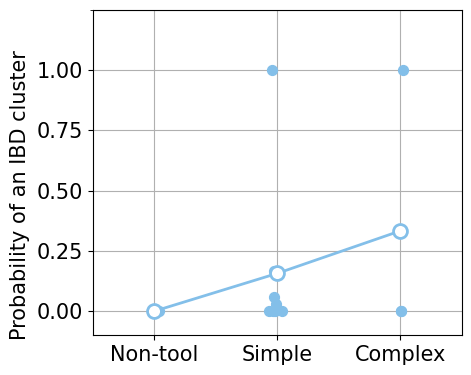

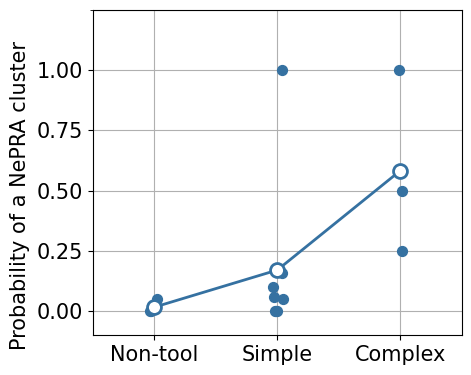

In [7]:
def fig_S9_AB(network, color):
    """
    Generates and saves a scatter plot for the probability of clusters in a given network.

    This function reads network data and tool affinity data, calculates the probability of clusters (triangles) 
    for different tool affinities, and plots the results.

    Parameters:
    network (str): The name of the network to analyze. It should correspond to a CSV file with the network's edgelist.
    color (str): The color to use for the plot.

    Returns:
    None

    Example:
    >>> fig_S9_AB(network='IBD', color='#83bfe9')
    >>> fig_S9_AB(network='NePRA', color='#3571a1')

    The function performs the following steps:
    1. Reads the network edgelist from a CSV file.
    2. Filters the network data based on 'neprasimilarity' if the column exists.
    3. Constructs a graph from the edgelist.
    4. Iterates over different tool affinities ('nontool', 'simple', 'complex').
    5. Reads the tool affinity data from CSV files.
    6. For each tool, identifies triangles in the network and calculates the probability of these triangles.
    7. Plots the results as scatter plots and saves the figure as a PNG file.

    Note:
    - The function assumes the existence of CSV files for the network edgelist and tool affinities.
    - The CSV files should be located in the directory specified by the variable `dat_path`.
    - The output figure is saved in the directory specified by the variable `fig_path`.

    """

    ori_color = color
    aff_list = ['nontool', 'simple', 'complex']

    network_dat = pd.read_csv(dat_path+f'/{network}_edgelist.csv', delimiter=';')

    try:
        network_dat = network_dat[network_dat['neprasimilarity'] >= 0.002]
    except:
        pass
    
    this_graph = nx.from_pandas_edgelist(network_dat, 'site1', 'site2')

    _full_dat = [[] for x in range(len(aff_list))]

    for aff in aff_list:
        _tool_dat = pd.read_csv(dat_path+f'{aff}_aff.csv', delimiter=';')
        _tool_dat = _tool_dat.rename(columns={'Unnamed: 0': 'site'})

        _tool_list = list(_tool_dat.columns[1:])

        for tool in _tool_list:
            this_tool_dat = _tool_dat[['site', tool]]

            # Filter data for the current tool
            this_tool_dat = this_tool_dat[this_tool_dat[tool] == 1]
            this_tool_all_triangles = list(itertools.combinations(this_tool_dat['site'], 3))

            if len(this_tool_all_triangles) == 0:
                continue
            count = count_triangles(this_graph, this_tool_all_triangles)
            _full_dat[aff_list.index(aff)].append(count/len(this_tool_all_triangles))

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    shift = 0.03
    
    # Plot original data
    for i in range(3):
        x_ticks = [np.random.normal(i, shift) for x in range(len(_full_dat[i]))]
        ax.scatter(x_ticks, _full_dat[i], marker='o', color=ori_color, s=50, zorder=2)

    x_ticks = [0, 1, 2]
    y_dat = [np.mean(_full_dat[0]), np.mean(_full_dat[1]), np.mean(_full_dat[2])]
    ax.plot(x_ticks, y_dat, color=ori_color, linewidth=2, 
            marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2, zorder=10)

    ax.set_xticks(x_ticks, ['Non-tool', 'Simple', 'Complex'], fontsize=text_font)

    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    if network == 'IBD':
        ax.set_ylabel(f'Probability of an IBD cluster', fontsize=text_font)
    else:
        ax.set_ylabel(f'Probability of a NePRA cluster', fontsize=text_font)

    ax.yaxis.set_label_coords(-0.17, 0.43)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.1, 1.25)

    ax = plt.gca()  # Get the current Axes instance
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

    plt.grid(which='both')
    plt.tight_layout()
    # plt.savefig(fig_path + f'fig_S9_AB_{network}.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    plt.close()
    
fig_S9_AB(network='IBD', color='#83bfe9')
fig_S9_AB(network='NePRA', color='#3571a1')